## Bias testing 
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'RF $T_{\mathrm{mean \ daily}}$'
TRUE = 'CERRA $T_{\mathrm{mean \ daily}}$'

In [3]:
PRED

'RF $T_{\\mathrm{mean \\ daily}}$'

### Imports

In [4]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [5]:
if PREDICTAND == 'tasmin':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/grid_search/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2_dem_sa_doy.nc")
    
if PREDICTAND == 'tasmax':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/grid_search/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2_dem_sa_doy.nc")
    
if PREDICTAND == 'tasmean':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/base_models/RESULTS/tasmean/RandomForestRegressor_tasmean_ztuvq_500_850_mslpt2m_dem_doy.nc")    

y_pred
                    

<xarray.Dataset> Size: 226MB
Dimensions:  (time: 1826, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x) float64 226MB ...

In [6]:
y_pred = y_pred - 273.15

In [7]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_tasmin_2m_temperature_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_tasmax_2m_temperature_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [10]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2020


In [11]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [12]:
y_true

<xarray.DataArray 'tasmean' (time: 1826, y: 96, x: 161)> Size: 113MB
array([[[10.06369   ,  9.825775  ,  9.550079  , ...,  8.7117    ,
          9.25293   ,  9.128937  ],
        [ 9.7388    ,  9.48941   ,  9.148376  , ...,  7.2322693 ,
          7.5288696 ,  6.274292  ],
        [ 9.55423   ,  9.218109  ,  8.879974  , ...,  6.3025513 ,
          5.1644287 ,  4.231262  ],
        ...,
        [ 4.3807983 ,  4.4526978 ,  4.3851013 , ..., -2.1247253 ,
         -2.0166626 , -1.8519592 ],
        [ 4.5255127 ,  4.5939026 ,  4.4677124 , ..., -1.5125427 ,
         -1.4614563 , -1.4924622 ],
        [ 4.7895203 ,  4.918579  ,  4.742157  , ..., -1.4219055 ,
         -1.5484009 , -1.7154541 ]],

       [[10.33728   , 10.041199  ,  9.779144  , ..., 11.216064  ,
         11.627502  , 11.047791  ],
        [ 9.855988  ,  9.627838  ,  9.470245  , ...,  9.825958  ,
          9.895905  ,  8.558563  ],
        [ 9.858856  ,  9.419952  ,  9.19104   , ...,  8.641022  ,
          7.345825  ,  6.568451  ],
...
        [ 1.1291199 ,  1.0311584 ,  0.8732605 , ...,  2.4204712 ,
          2.5972595 ,  3.0231323 ],
        [ 1.0886536 ,  1.0751648 ,  0.87301636, ...,  3.6161194 ,
          3.978302  ,  4.1756897 ],
        [ 1.3735657 ,  1.4538879 ,  1.197876  , ...,  4.541809  ,
          4.575836  ,  4.458832  ]],

       [[ 2.324646  ,  2.1434326 ,  1.9787903 , ..., 13.167084  ,
         13.665649  , 13.616547  ],
        [ 1.9729614 ,  1.5584412 ,  1.6370544 , ..., 12.347626  ,
         12.814331  , 12.362122  ],
        [ 1.8825989 ,  1.4822998 ,  1.3814087 , ..., 12.472656  ,
         11.874481  , 11.518127  ],
        ...,
        [ 1.0103455 ,  0.9259949 ,  0.81155396, ..., -0.05187988,
          0.10299683,  0.34005737],
        [ 1.1213074 ,  1.039917  ,  0.84017944, ...,  0.5721741 ,
          0.7281494 ,  0.7475281 ],
        [ 1.4971008 ,  1.4839172 ,  1.2037659 , ...,  0.766449  ,
          0.7253418 ,  0.5571594 ]]], dtype=float32)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 15kB 2016-01-01 ... 2020-12-30

In [13]:
y_pred

<xarray.DataArray 'tasmean' (time: 1826, y: 96, x: 161)> Size: 226MB
array([[[10.06467285,  9.61666016,  9.12638885, ...,  8.20848877,
          8.80627228,  8.46305054],
        [ 9.43089203,  8.96383301,  8.8057785 , ...,  6.98373901,
          6.93463806,  5.69555176],
        [ 9.45442596,  8.89924744,  8.8952655 , ...,  6.30656616,
          4.76204742,  4.31512451],
        ...,
        [ 3.33074219,  3.63554626,  3.45686218, ..., -2.04105988,
         -1.81976563, -1.5631073 ],
        [ 3.30489594,  3.40584198,  3.72042175, ..., -1.71589722,
         -1.44340393, -1.38957092],
        [ 3.58117371,  3.87725708,  3.64277222, ..., -1.00894623,
         -1.05458893, -1.06046814]],

       [[ 9.93183533,  9.73640106,  9.61043549, ..., 10.46290894,
         10.75650818, 10.8017157 ],
        [ 9.70600739,  9.50470032,  9.06219208, ...,  8.97200134,
          9.13671875,  8.23008362],
        [ 9.52683868,  9.18756836,  8.90441681, ...,  8.17815857,
          7.26572937,  6.20596344],
...
        [ 0.64671814,  0.77338409,  0.74542114, ...,  2.01705597,
          2.16418701,  2.39076233],
        [ 0.69299805,  0.72611969,  0.59065735, ...,  2.90223785,
          3.02686249,  3.18471985],
        [ 0.93097473,  0.9569577 ,  0.78346375, ...,  3.26632599,
          3.32996826,  3.22526062]],

       [[ 3.27615906,  2.92513855,  2.45810669, ..., 12.67369537,
         13.31916718, 13.10006653],
        [ 2.62287445,  2.19940704,  2.02884552, ..., 11.80767792,
         12.21778351, 11.74572998],
        [ 2.2967746 ,  1.82508606,  1.75488953, ..., 11.4300705 ,
         10.8445639 , 10.28723846],
        ...,
        [ 1.65251312,  1.53528107,  1.38016602, ..., -0.50363739,
         -0.36395691, -0.07539398],
        [ 1.44008759,  1.46376923,  1.36647064, ...,  0.13710907,
          0.40040192,  0.62646545],
        [ 1.62974915,  1.6955719 ,  1.46192627, ...,  0.42539581,
          0.31368591,  0.6934613 ]]])
Coordinates:
  * time     (time) datetime64[ns] 15kB 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82

In [14]:
### calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [15]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [16]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [17]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 1.00
R2 on daily anomalies: 0.95


### Coefficient of determination: Spatially

In [18]:
# iterate over the grid points
r2 = np.ones((2,  len(y_pred.y), len(y_pred.x)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, j, i] = r2_score(point_true, point_pred)
        r2[1, j, i] = r2_score(point_anom_true, point_anom_pred)

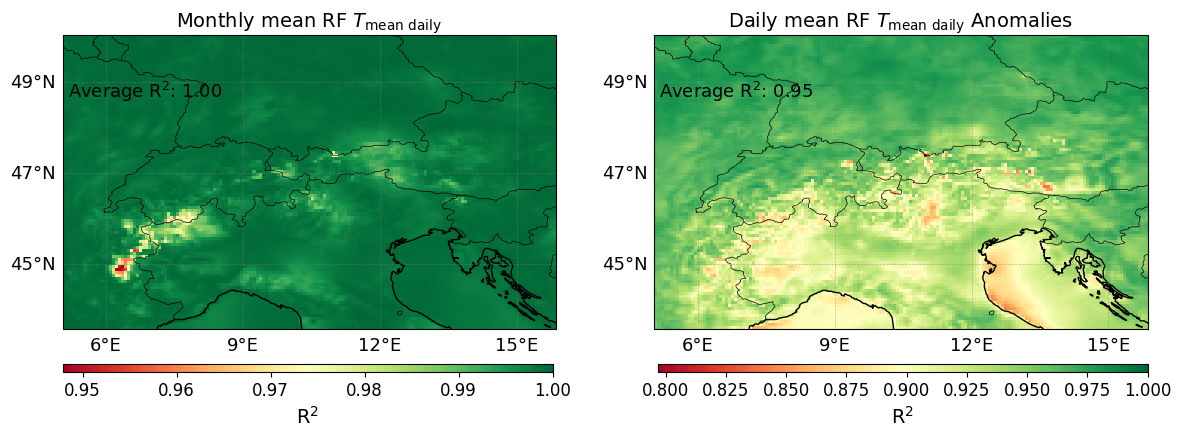

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

x_values = y_true.x.values
y_values = y_true.y.values
r22 = xr.DataArray(
    r2,
    dims=('number', 'y', 'x'),
    coords={'x': x_values, 'y': y_values}
)
# Set the CRS to EPSG 4326
r22.rio.set_crs("EPSG:4326", inplace=True)

# Plot each number separately
numbers = [0, 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), subplot_kw={'projection': ccrs.PlateCarree()})

cbar_axes = [None] * 2  # Create an empty list to store colorbar axes

for i, number in enumerate(numbers):
    ax = axes[i]
    
    # Select data for the current number
    ds_number = r22.sel(number=number)
    
    # Plot the data
    if i == 0:
        im = ds_number.plot(ax=ax, cmap='RdYlGn', vmin=ds_number.min().values, vmax=1, add_colorbar=False)
        cbar_axes[i] = fig.add_axes([0.125, 0.02, 0.35, 0.02])
        cbar = fig.colorbar(im, cax=cbar_axes[i], orientation='horizontal')
    elif i == 1:
        im = ds_number.plot(ax=ax, cmap='RdYlGn', vmin=ds_number.min().values, vmax=1, add_colorbar=False)
        cbar_axes[i] = fig.add_axes([0.55, 0.02, 0.35, 0.02])
        cbar = fig.colorbar(im, cax=cbar_axes[i], orientation='horizontal')
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}

    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove y-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    
    # Set title
    if i == 0:
        ax.set_title('Monthly mean {} '.format(PRED), fontsize=14)
        ax.text(0.01, 0.85, 'Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')

    elif i == 1:
        ax.set_title('Daily mean {} Anomalies'.format(PRED), fontsize=14)
        ax.text(0.01, 0.85, 'Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')



# Customize colorbars
cbar_axes[0].set_xlabel('R$^2$', fontsize=14)
cbar_axes[1].set_xlabel('R$^2$', fontsize=14)
cbar_axes[0].xaxis.set_tick_params(labelsize=12)
cbar_axes[1].xaxis.set_tick_params(labelsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust spacing between subplots
plt.show()


# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_r2_spatial_rf.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [20]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Yearly average bias of tasmean: -0.05°C


In [21]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Yearly average MAE of tasmean: 0.18°C


In [22]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Yearly average RMSE of tasmean: 0.24°C


In [23]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(2016): 1.00
(2017): 1.00
(2018): 1.00
(2019): 1.00
(2020): 1.00
Yearly average Pearson correlation coefficient for tasmean: 1.00


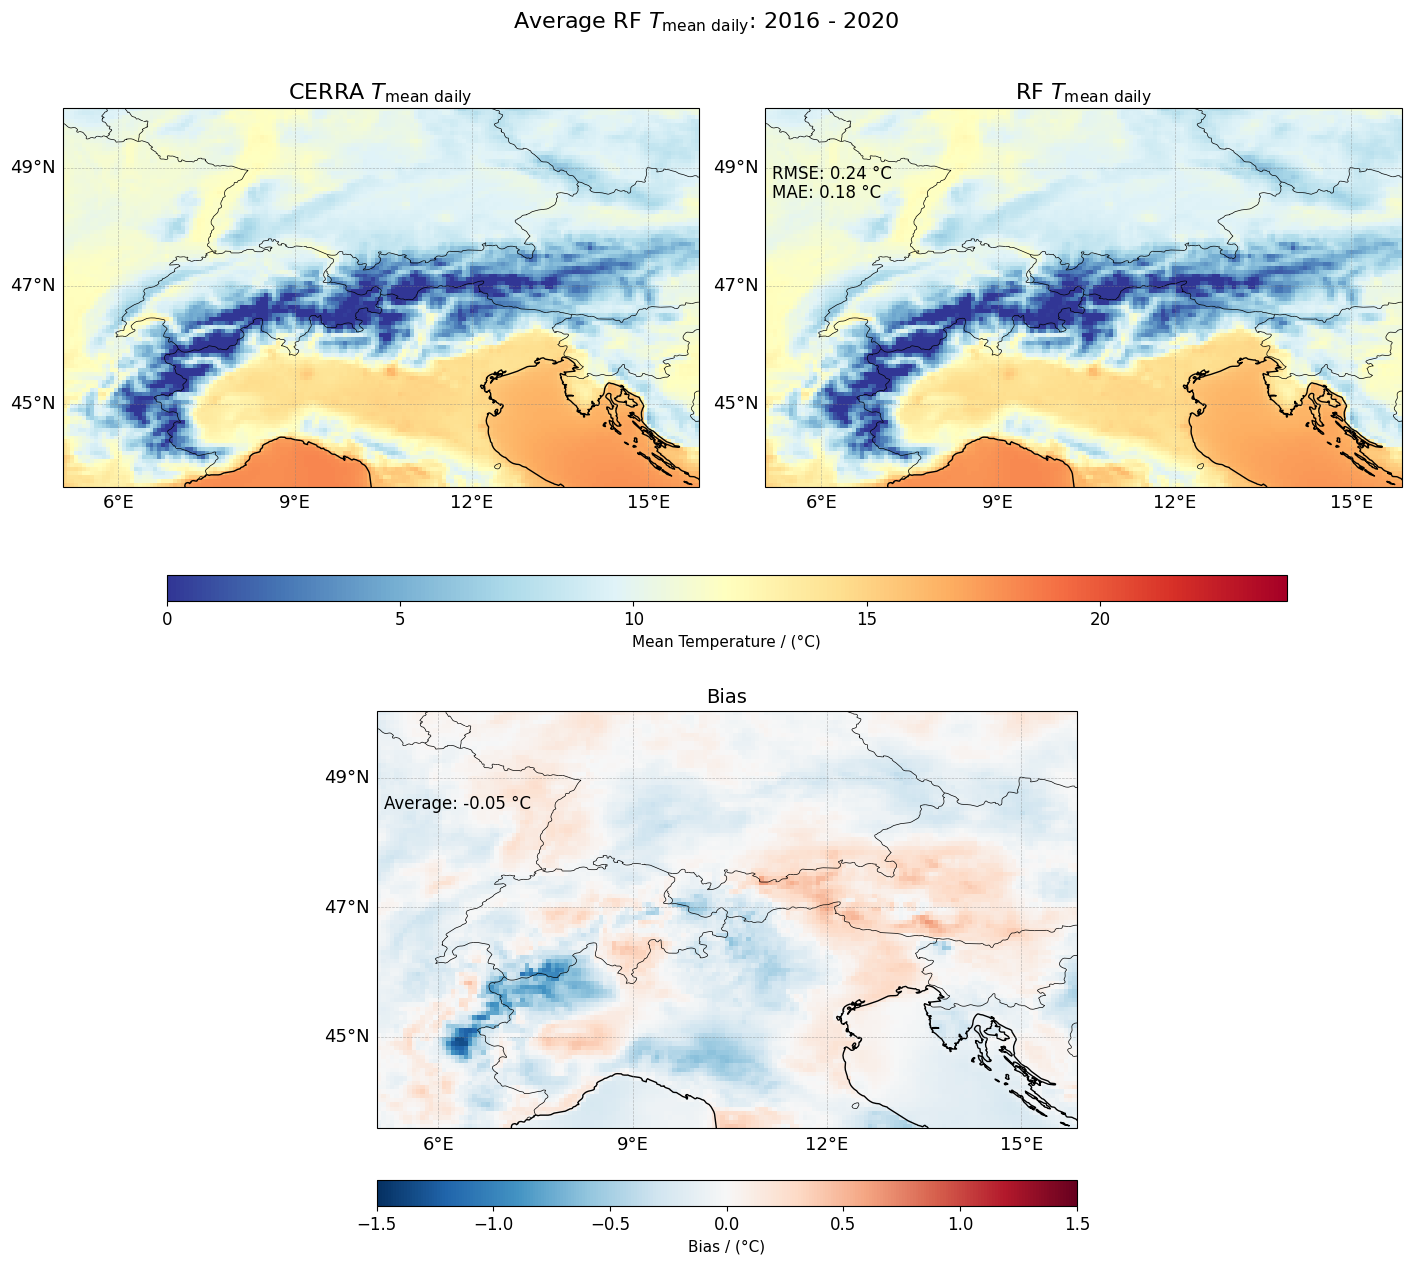

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
ds_true_mean = y_true_yearly_avg.mean(dim="year")
ds_pred_mean = y_pred_yearly_avg.mean(dim="year")
ds_true_mean.rio.set_crs("EPSG:4326", inplace=True)
ds_pred_mean.rio.set_crs("EPSG:4326", inplace=True)
ds_true_mean = ds_true_mean.drop_vars("heightAboveGround")
bias = ds_pred_mean - ds_true_mean

# Add a new dimension named 'number' with values [0, 1, 2] to each data array
three = xr.concat([ds_true_mean, ds_pred_mean, bias], dim='number')

# Plot each number separately
numbers = [0, 1, 2]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True, gridspec_kw={'top': 5})

for i, number in enumerate(numbers):
    if i == 2:
        ax = axes[1, 0]  # Bias plot centered in the second row
        ax.set_position([0.265, 0.07, 0.5, 0.4])  # Adjust position to center
    else:
        ax = axes[i // 2, i % 2]  # Adjust row and column index
    
    
    # Select data for the current number
    ds_number = three.sel(number=number)
    
    # Plot the data
    if i == 2:
        im = ds_number.plot(ax=ax, cmap='RdBu_r', vmin=-1.5, vmax=1.5, add_colorbar=False)
    else:
        img = ds_number.plot(ax=ax, cmap='RdYlBu_r', vmin=0, vmax=24, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}

    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove x-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    
    # Set title
    if i == 0:
        ax.set_title(TRUE, fontsize=16)
    elif i == 1:
        ax.set_title(PRED, fontsize=16)
        ax.text(0.01, 0.85, "RMSE: {:.2f} °C".format(rmse_avg.item()), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')
        ax.text(0.01, 0.8, "MAE: {:.2f} °C".format(mae_avg.item()), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')
    elif i == 2:
        ax.set_title('Bias', fontsize=14)
        ax.text(0.01, 0.8, "Average: {:.2f} °C".format(ds_number.mean().item()), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')

fig.suptitle('Average {}: {} - {}'.format(PRED, start_year, end_year), fontsize=16, y=0.97);

# Create a common colorbar for bias
cbar_ax_bias = fig.add_axes([0.115, 0.515, 0.8, 0.02])  # Adjust height to fit properly
cbar_bias = fig.colorbar(img, cax=cbar_ax_bias, orientation='horizontal')
cbar_bias.set_label('Mean Temperature / (°C)', fontsize=11)
cbar_bias.ax.tick_params(labelsize=12)
# Hide the empty subplot
fig.delaxes(axes[1, 1])

# Add a separate colorbar for the second row plot
cbar_ax_second_row = fig.add_axes([0.265, 0.05, 0.5, 0.02])  # Adjust height to fit properly
cbar_second_row = fig.colorbar(im, cax=cbar_ax_second_row, orientation='horizontal')
cbar_second_row.set_label('Bias / (°C)', fontsize=11)  # Set your label
cbar_second_row.ax.tick_params(labelsize=12)
#cbar_second_row.set_ticks([your_ticks])  # Set your ticks
#cbar_second_row.set_ticklabels([your_tick_labels])  # Set your tick labels

plt.show()


# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_average_bias_rf.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [25]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [26]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season DJF: -0.1°C
(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season JJA: -0.1°C
(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season MAM: -0.1°C
(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season SON: -0.0°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

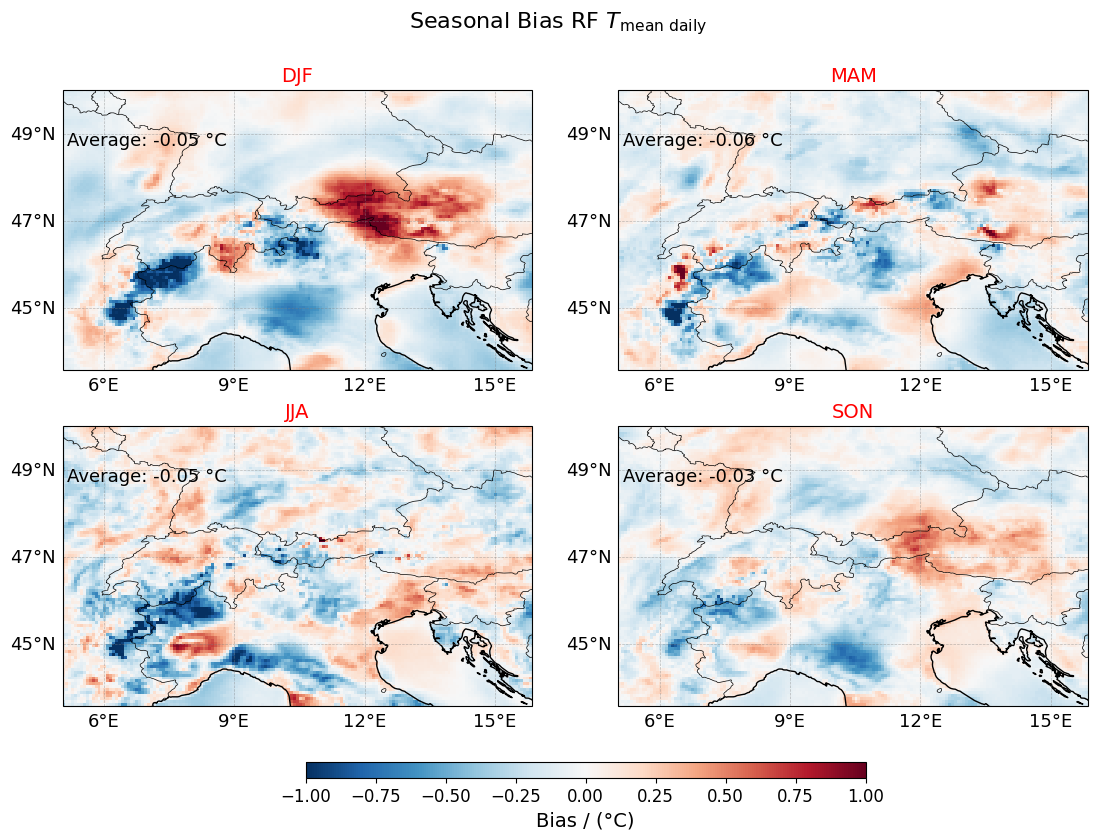

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
bias_snl.rio.set_crs("EPSG:4326", inplace=True)

# Plot each season separately
seasons = ['DJF', 'MAM', 'JJA', 'SON']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

for i, season in enumerate(seasons):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Select data for the current season
    ds_season = bias_snl.sel(season=season)
    
    # Plot the data
    im = ds_season.plot(ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}



    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove y-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    # Set title
    ax.set_title('{}'.format(season), fontsize=14, color="red")
    ax.text(0.01, 0.85, 'Average: {:.2f} °C'.format(ds_season.mean()), ha='left', va='top', transform=ax.transAxes, fontsize=13, color='black')

fig.suptitle('Seasonal Bias {}'.format(PRED), fontsize=16);

# Add colorbar at the bottom
cbar_ax_predictand = fig.add_axes([0.32, 0.02, 0.4, 0.02])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Bias / (°C)', fontsize=14)
cbar_predictand.ax.tick_params(labelsize=12)

plt.subplots_adjust(wspace=0.05, hspace=0.2)  # Adjust spacing between subplots
plt.show()

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_bias_seasonal_rf.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')


### Bias of extreme values

In [28]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [29]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [30]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [31]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Yearly average bias for P98 of tasmean: -0.2°C


In [32]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [33]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Yearly average MAE for P98 of tasmean: 0.5°C


In [34]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [35]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(CERRA $T_{\mathrm{mean \ daily}}$:RF $T_{\mathrm{mean \ daily}}$) Yearly average RMSE for P98 of tasmean: 0.7°C


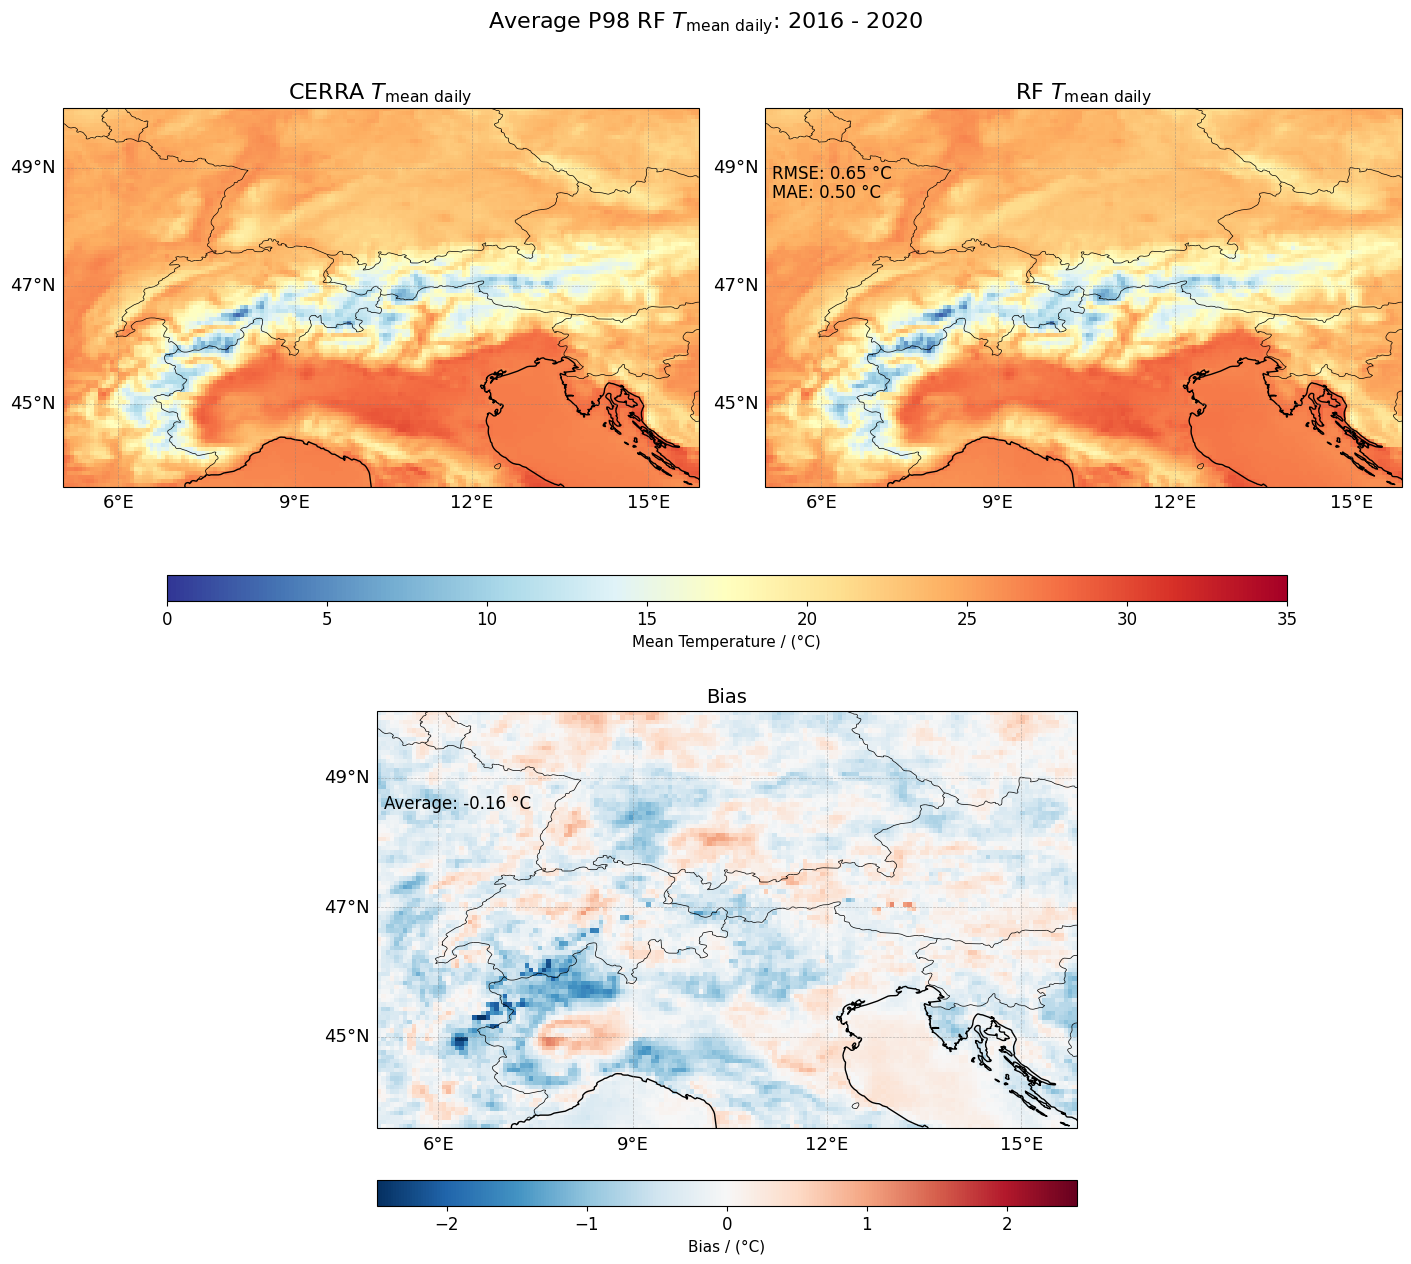

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.ticker as mticker

# Assuming you have your bias_snl xarray dataarray object
# Set the CRS to EPSG 4326
ds_true_ex = y_true_ex.mean(dim="year")
ds_pred_ex = y_pred_ex.mean(dim="year")
ds_true_ex.rio.set_crs("EPSG:4326", inplace=True)
ds_pred_ex.rio.set_crs("EPSG:4326", inplace=True)
#ds_true_ex = ds_true_ex.drop_vars("heightAboveGround")
bias_ex = ds_pred_ex - ds_true_ex

# Add a new dimension named 'number' with values [0, 1, 2] to each data array
ex = xr.concat([ds_true_ex, ds_pred_ex, bias_ex], dim='number')

# Plot each number separately
numbers = [0, 1, 2]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

for i, number in enumerate(numbers):
    if i == 2:
        ax = axes[1, 0]  # Bias plot centered in the second row
        ax.set_position([0.265, 0.07, 0.5, 0.4])  # Adjust position to center
        
    else:
        ax = axes[i // 2, i % 2]  # Adjust row and column index
    
    
    # Select data for the current number
    ds_number = ex.sel(number=number)
    
    # Plot the data
    if i == 2:
        im = ds_number.plot(ax=ax, cmap='RdBu_r', vmin=-2.5, vmax=2.5, add_colorbar=False)
    else:
        img = ds_number.plot(ax=ax, cmap='RdYlBu_r', vmin=0, vmax=35, add_colorbar=False)
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='solid', edgecolor='black')
    
    # Add coastlines
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.bottom_labels = True
    gl.left_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([6, 9, 12, 15])
    gl.ylocator = mticker.FixedLocator([45, 47, 49])
    gl.xlabel_style = {'size': 13}  # Adjust the font size as needed
    gl.ylabel_style = {'size': 13}

    # Remove x-axis and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])

    # Remove x-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    
    # Set title
    if i == 0:
        ax.set_title(TRUE, fontsize=16)
    elif i == 1:
        ax.set_title(PRED, fontsize=16)
        # Add text with RMSE and MAE values
        ax.text(0.01, 0.85, "RMSE: {:.2f} °C".format(rmse_ex.item()), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')
        ax.text(0.01, 0.8, "MAE: {:.2f} °C".format(mae_ex.item()), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')
    elif i == 2:
        ax.set_title('Bias', fontsize=14)
        ax.text(0.01, 0.8, "Average: {:.2f} °C".format(ds_number.mean().item()), ha='left', va='top', transform=ax.transAxes, fontsize=12, color='black')

fig.suptitle('Average P98 {}: {} - {}'.format(PRED, start_year, end_year), fontsize=16, y=0.97);

# Create a common colorbar for bias
cbar_ax_bias = fig.add_axes([0.115, 0.515, 0.8, 0.02])  # Adjust height to fit properly
cbar_bias = fig.colorbar(img, cax=cbar_ax_bias, orientation='horizontal')
cbar_bias.set_label('Mean Temperature / (°C)', fontsize=11)
cbar_bias.ax.tick_params(labelsize=12)
# Hide the empty subplot
fig.delaxes(axes[1, 1])

# Add a separate colorbar for the second row plot
cbar_ax_second_row = fig.add_axes([0.265, 0.05, 0.5, 0.02])  # Adjust height to fit properly
cbar_second_row = fig.colorbar(im, cax=cbar_ax_second_row, orientation='horizontal')
cbar_second_row.set_label('Bias / (°C)', fontsize=11)  # Set your label
cbar_second_row.ax.tick_params(labelsize=12)

plt.show()

# save figure
fig.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/{}_bias_p{:.0f}_rf.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

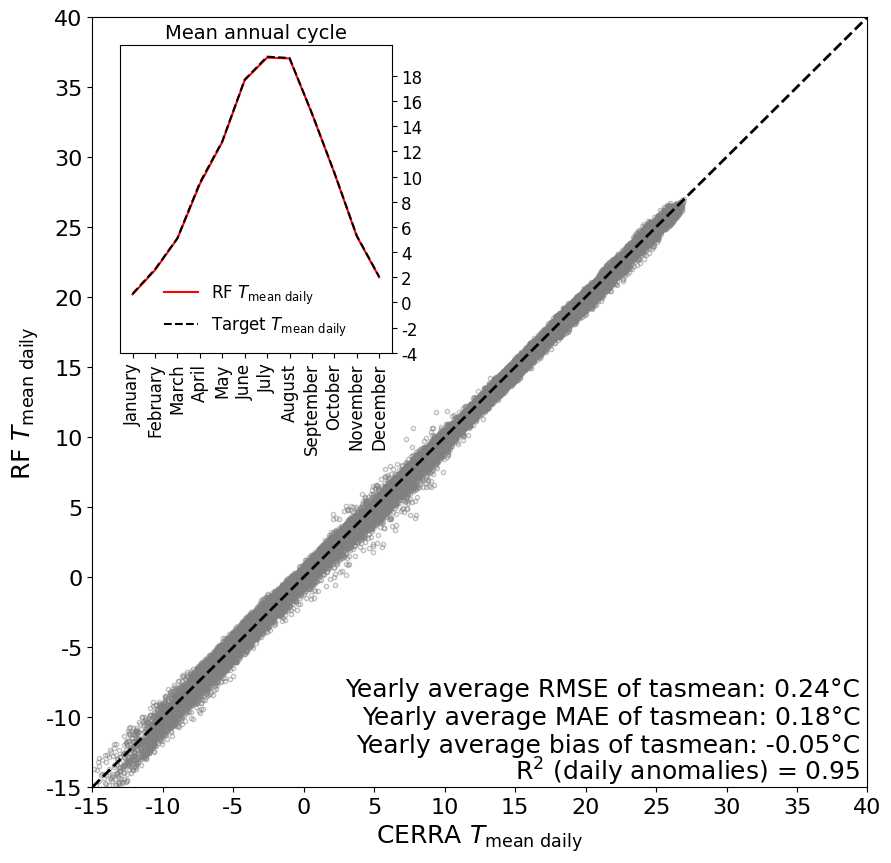

In [38]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
#ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA $T_{\mathrm{mean \ daily}}$', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
#ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=2)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='Target $T_{\mathrm{mean \ daily}}$')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('/home/sdhinakaran/eurac/downScaleML/Notebooks/Thesis_Results/plots/mslp_rf.png', dpi=300, bbox_inches='tight')
